## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.95MB/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.19MB/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [8]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super(TinyNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

In [9]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 128]          65,664
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.79
Estimated Total Size (MB): 1.81
----------------------------------------------------------------


Your experiments come here:

In [10]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, training and validation loops here
def train_epoch(model, train_loader, loss_func, optimizer):
    model.train()
    train_loss, correct = 0, 0
    total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
        total += x.size(0)
    return train_loss / total, correct / total

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total

In [11]:
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, loss_func, opt)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/30, Loss: 0.5346, Train Acc: 0.8100, Test Acc: 0.8498
Epoch 2/30, Loss: 0.3739, Train Acc: 0.8644, Test Acc: 0.8556
Epoch 3/30, Loss: 0.3317, Train Acc: 0.8781, Test Acc: 0.8692
Epoch 4/30, Loss: 0.3098, Train Acc: 0.8845, Test Acc: 0.8712
Epoch 5/30, Loss: 0.2891, Train Acc: 0.8930, Test Acc: 0.8770
Epoch 6/30, Loss: 0.2730, Train Acc: 0.8982, Test Acc: 0.8797
Epoch 7/30, Loss: 0.2608, Train Acc: 0.9021, Test Acc: 0.8806
Epoch 8/30, Loss: 0.2521, Train Acc: 0.9049, Test Acc: 0.8767
Epoch 9/30, Loss: 0.2354, Train Acc: 0.9106, Test Acc: 0.8868
Epoch 10/30, Loss: 0.2246, Train Acc: 0.9152, Test Acc: 0.8842
Epoch 11/30, Loss: 0.2203, Train Acc: 0.9166, Test Acc: 0.8891
Epoch 12/30, Loss: 0.2107, Train Acc: 0.9208, Test Acc: 0.8901
Epoch 13/30, Loss: 0.1986, Train Acc: 0.9243, Test Acc: 0.8820
Epoch 14/30, Loss: 0.1921, Train Acc: 0.9275, Test Acc: 0.8877
Epoch 15/30, Loss: 0.1865, Train Acc: 0.9295, Test Acc: 0.8807
Epoch 16/30, Loss: 0.1798, Train Acc: 0.9318, Test Acc: 0.8889
E

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [12]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super(OverfittingNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

In [13]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
Total params: 1,462,538
Trainable params: 1,462,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 5.58
Estimated Total Size (MB): 5.62
----------------------------------------------------------------


In [14]:
small_train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(fmnist_dataset_train, range(5000)),
    batch_size=128, shuffle=True, num_workers=2
)

Epoch 1/30, Loss: 0.1082, Train Acc: 0.9572, Test Acc: 0.8900
Epoch 2/30, Loss: 0.0903, Train Acc: 0.9638, Test Acc: 0.8941
Epoch 3/30, Loss: 0.0615, Train Acc: 0.9778, Test Acc: 0.9017
Epoch 4/30, Loss: 0.0455, Train Acc: 0.9866, Test Acc: 0.8998
Epoch 5/30, Loss: 0.0418, Train Acc: 0.9856, Test Acc: 0.8948
Epoch 6/30, Loss: 0.0562, Train Acc: 0.9786, Test Acc: 0.8979
Epoch 7/30, Loss: 0.0327, Train Acc: 0.9900, Test Acc: 0.8953
Epoch 8/30, Loss: 0.0576, Train Acc: 0.9786, Test Acc: 0.8955
Epoch 9/30, Loss: 0.0364, Train Acc: 0.9872, Test Acc: 0.8895
Epoch 10/30, Loss: 0.0388, Train Acc: 0.9882, Test Acc: 0.8933
Epoch 11/30, Loss: 0.0365, Train Acc: 0.9884, Test Acc: 0.8932
Epoch 12/30, Loss: 0.0254, Train Acc: 0.9924, Test Acc: 0.8962
Epoch 13/30, Loss: 0.0155, Train Acc: 0.9966, Test Acc: 0.8935
Epoch 14/30, Loss: 0.0120, Train Acc: 0.9980, Test Acc: 0.8963
Epoch 15/30, Loss: 0.0092, Train Acc: 0.9984, Test Acc: 0.8970
Epoch 16/30, Loss: 0.0079, Train Acc: 0.9986, Test Acc: 0.8976
E

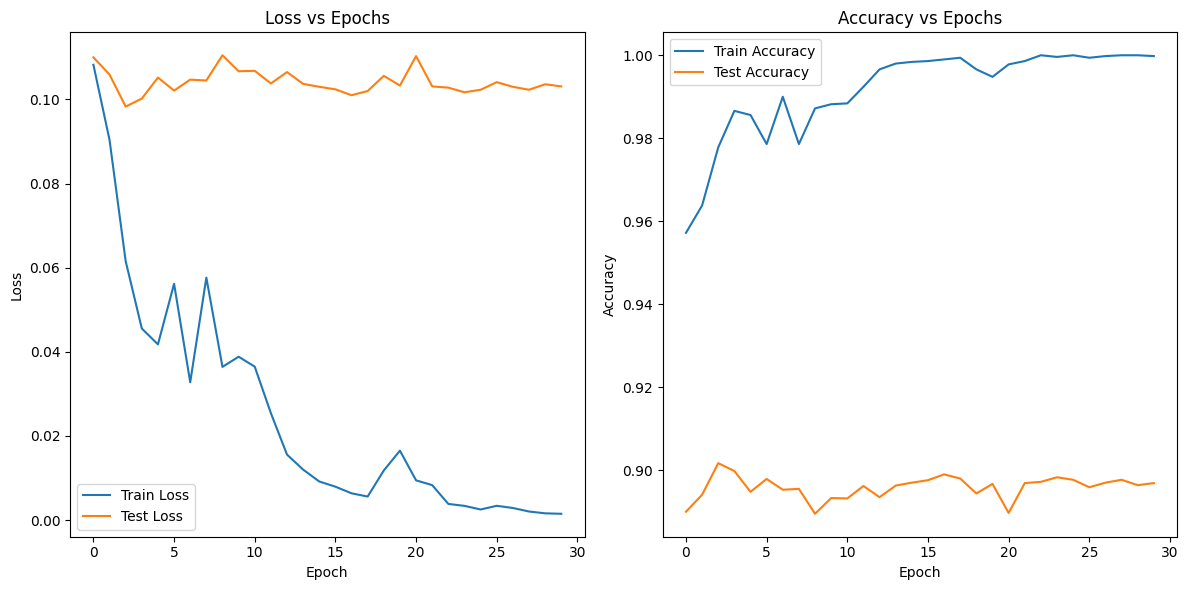

In [15]:
train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, small_train_loader, loss_func, opt)
    test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_losses.append(1 - test_acc)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [16]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super(FixedNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

In [17]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 128]          65,664
       BatchNorm1d-7                  [-1, 128]             256
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 470,154
Trainable params: 470,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.79
Estimated T

In [18]:
fixed_model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
train_losses, test_losses, train_accs, test_accs = [], [], [], []

def train_epoch(model, dataloader, loss_func, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        _, predicted = preds.max(1)
        correct += predicted.eq(y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            _, predicted = preds.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)
    return correct / total

model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()

num_epochs = 30
train_losses, train_accuracies = [], []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, loss_func, opt)
    test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/30, Loss: 0.5534, Train Acc: 0.8092, Test Acc: 0.8450
Epoch 2/30, Loss: 0.4174, Train Acc: 0.8503, Test Acc: 0.8617
Epoch 3/30, Loss: 0.3819, Train Acc: 0.8618, Test Acc: 0.8681
Epoch 4/30, Loss: 0.3657, Train Acc: 0.8652, Test Acc: 0.8656
Epoch 5/30, Loss: 0.3482, Train Acc: 0.8738, Test Acc: 0.8702
Epoch 6/30, Loss: 0.3380, Train Acc: 0.8760, Test Acc: 0.8780
Epoch 7/30, Loss: 0.3294, Train Acc: 0.8790, Test Acc: 0.8790
Epoch 8/30, Loss: 0.3220, Train Acc: 0.8821, Test Acc: 0.8756
Epoch 9/30, Loss: 0.3138, Train Acc: 0.8844, Test Acc: 0.8831
Epoch 10/30, Loss: 0.3098, Train Acc: 0.8859, Test Acc: 0.8814
Epoch 11/30, Loss: 0.3054, Train Acc: 0.8883, Test Acc: 0.8800
Epoch 12/30, Loss: 0.3031, Train Acc: 0.8884, Test Acc: 0.8786
Epoch 13/30, Loss: 0.2946, Train Acc: 0.8903, Test Acc: 0.8823
Epoch 14/30, Loss: 0.2891, Train Acc: 0.8930, Test Acc: 0.8869
Epoch 15/30, Loss: 0.2888, Train Acc: 0.8930, Test Acc: 0.8820
Epoch 16/30, Loss: 0.2869, Train Acc: 0.8953, Test Acc: 0.8880
E

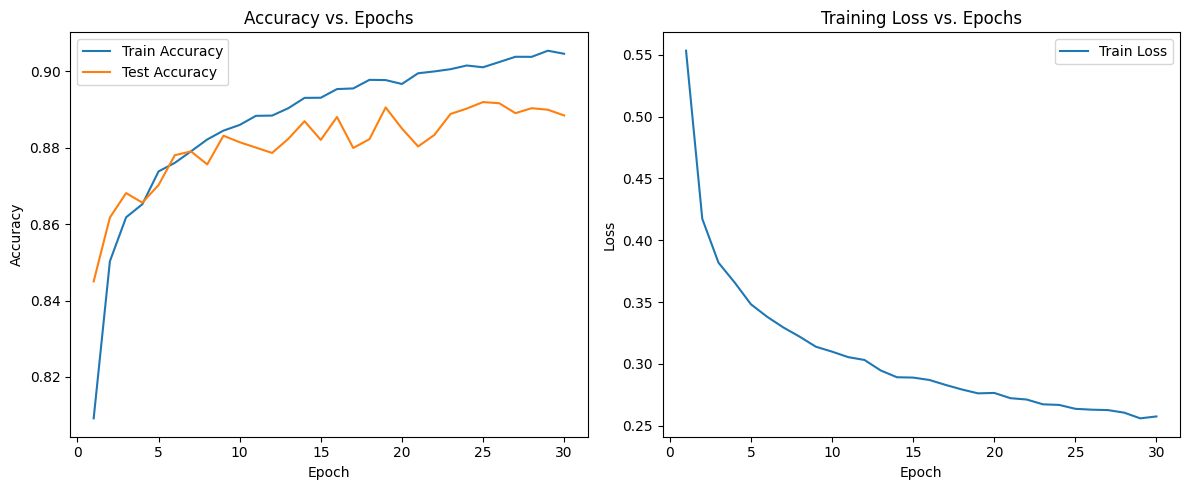

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()


### Conclusions:
_Write down small report with your conclusions and your ideas._

Регуляризационные методы, такие как Dropout, Batch Normalization и Weight Decay, ожидаемо уменьшают переобучение, улучшая обобщающую способность модели. В отличие от модели без регуляризации, в последней модели точность на тестовой выборке продолжала расти на протяжении всех эпох. Это свидетельствует о лучшей способности модели к обобщению и стабильной производительности как на обучающем, так и на валидационном наборе данных.